In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

In [3]:
#number of DoG fields to create, size of input matrix to consider, sigma of DoG 
#and mahalanobis distance from RF center for which values shall be computed
def generate_receptive_fields(count,size,sigma,mahalanobis=5):
    x_size=size[0]
    y_size=size[1]
    ganglions=[]
    #needed to determine which points still contribute to RF
    deviationfactor=np.max(sigma)
    radius=int(np.rint(np.sqrt(deviationfactor)*mahalanobis))
    #values that are the same for all positions and don't have to be calculated for each RF
    determinant_sqrt = np.sqrt(np.linalg.det(sigma))
    inverse = np.linalg.inv(sigma)    
    constant_factor= np.divide(1.0,np.multiply(2*np.pi,determinant_sqrt))
    #constant values for the outer gaussian, the covariance matrix is set to double of the center gaussian
    surround_sigma = sigma*2
    surround_determinant_sqrt = np.sqrt(np.linalg.det(surround_sigma))
    surround_inverse=np.linalg.inv(surround_sigma)
    constant_surround =np.divide(1.0,np.multiply(2*np.pi,surround_determinant_sqrt))
    #loop for each RF
    for i in range(0,count):
        #random sampling for a center in the image/'retina' area
        y_pos =np.random.randint(0,y_size)
        x_pos =np.random.randint(0,x_size)
        field=np.zeros((x_size,y_size))
        #compute contribution to RF activation for each point in a the radius around the center of the RF
        #the radius depends on the covariance matrix and the mahalanobis cutoff distance
        for x in range(x_pos-radius,x_pos+radius):
            for y in range(y_pos-radius,y_pos+radius):                 
                if((x-x_pos)**2+(y-y_pos)**2)<deviationfactor*mahalanobis**2:
                    #Difference of Gaussians value for the point
                    activationvalue=np.multiply(constant_factor,np.exp(np.multiply(-(1.0/2),[x-x_pos,y-y_pos])@inverse@(np.array([x-x_pos,y-y_pos]).transpose())))-np.multiply(constant_surround,np.exp(np.multiply(-(1.0/2),[x-x_pos,y-y_pos])@surround_inverse@(np.array([x-x_pos,y-y_pos]).transpose())))
                    #put contribution value to the pixel or add it to the edge of the 'retina' if it is outside
                    field[min(max(0,x),x_size-1),min(max(y,0),y_size-1)]+=activationvalue
        #add receptive field to the list
        ganglions.append(np.array(field))
    return ganglions

In [4]:
#computes activation of given ganglion list given an input image with values between 0 and 1
#the percentage of resulting activations can be set. a learning algorithm thus cannot simply learn on the number of activations for a category
def compute_normalized_output(ganglions,image,percentactivated=10):
    spikes=[]
    activations=[]
    #compute activation value for each RF
    for receptive_field in ganglions:    
        activations.append(np.sum(receptive_field*image))
    #spike threshold is dependend on the whished activated percentage
    threshold=np.percentile(activations,100-percentactivated)
    #0 or 1 is appended for each RF so that the given percentage of spikes is achieved
    for activation in activations:
        spikes.append(np.where(activation>threshold,1,0))
    return spikes

In [5]:
size = [333,500]
#covariance matrix for inner Gaussian
sigma=np.array([[70,0],[0,70]])
ganglion_count=250
mahalanobis=10

In [36]:
%time receptive_fields = generate_receptive_fields(ganglion_count,size,sigma,mahalanobis)

CPU times: user 1min 20s, sys: 21.3 ms, total: 1min 20s
Wall time: 1min 20s


In [37]:
#save the generated receptive fields for later use and consistency
np.savez_compressed(".../Code/receptive_compressed"+str(ganglion_count)+"-"+str(sigma[0][0])+"-"+str(mahalanobis),receptive=receptive_fields)

In [6]:
#load saved receptive fields
saved_receptive =np.load(".../Code/receptive_compressed250-70-10.npz")['receptive']

In [7]:
tofilter = np.array(Image.open(".../highlights/dog1outline.jpg"))
#color channels are simply added, simulating monochromatic input (ganglions are not color-specific)
added = np.float_(np.sum(tofilter,axis=2))
#input levels between 0 and 1
normalized =added/765.0

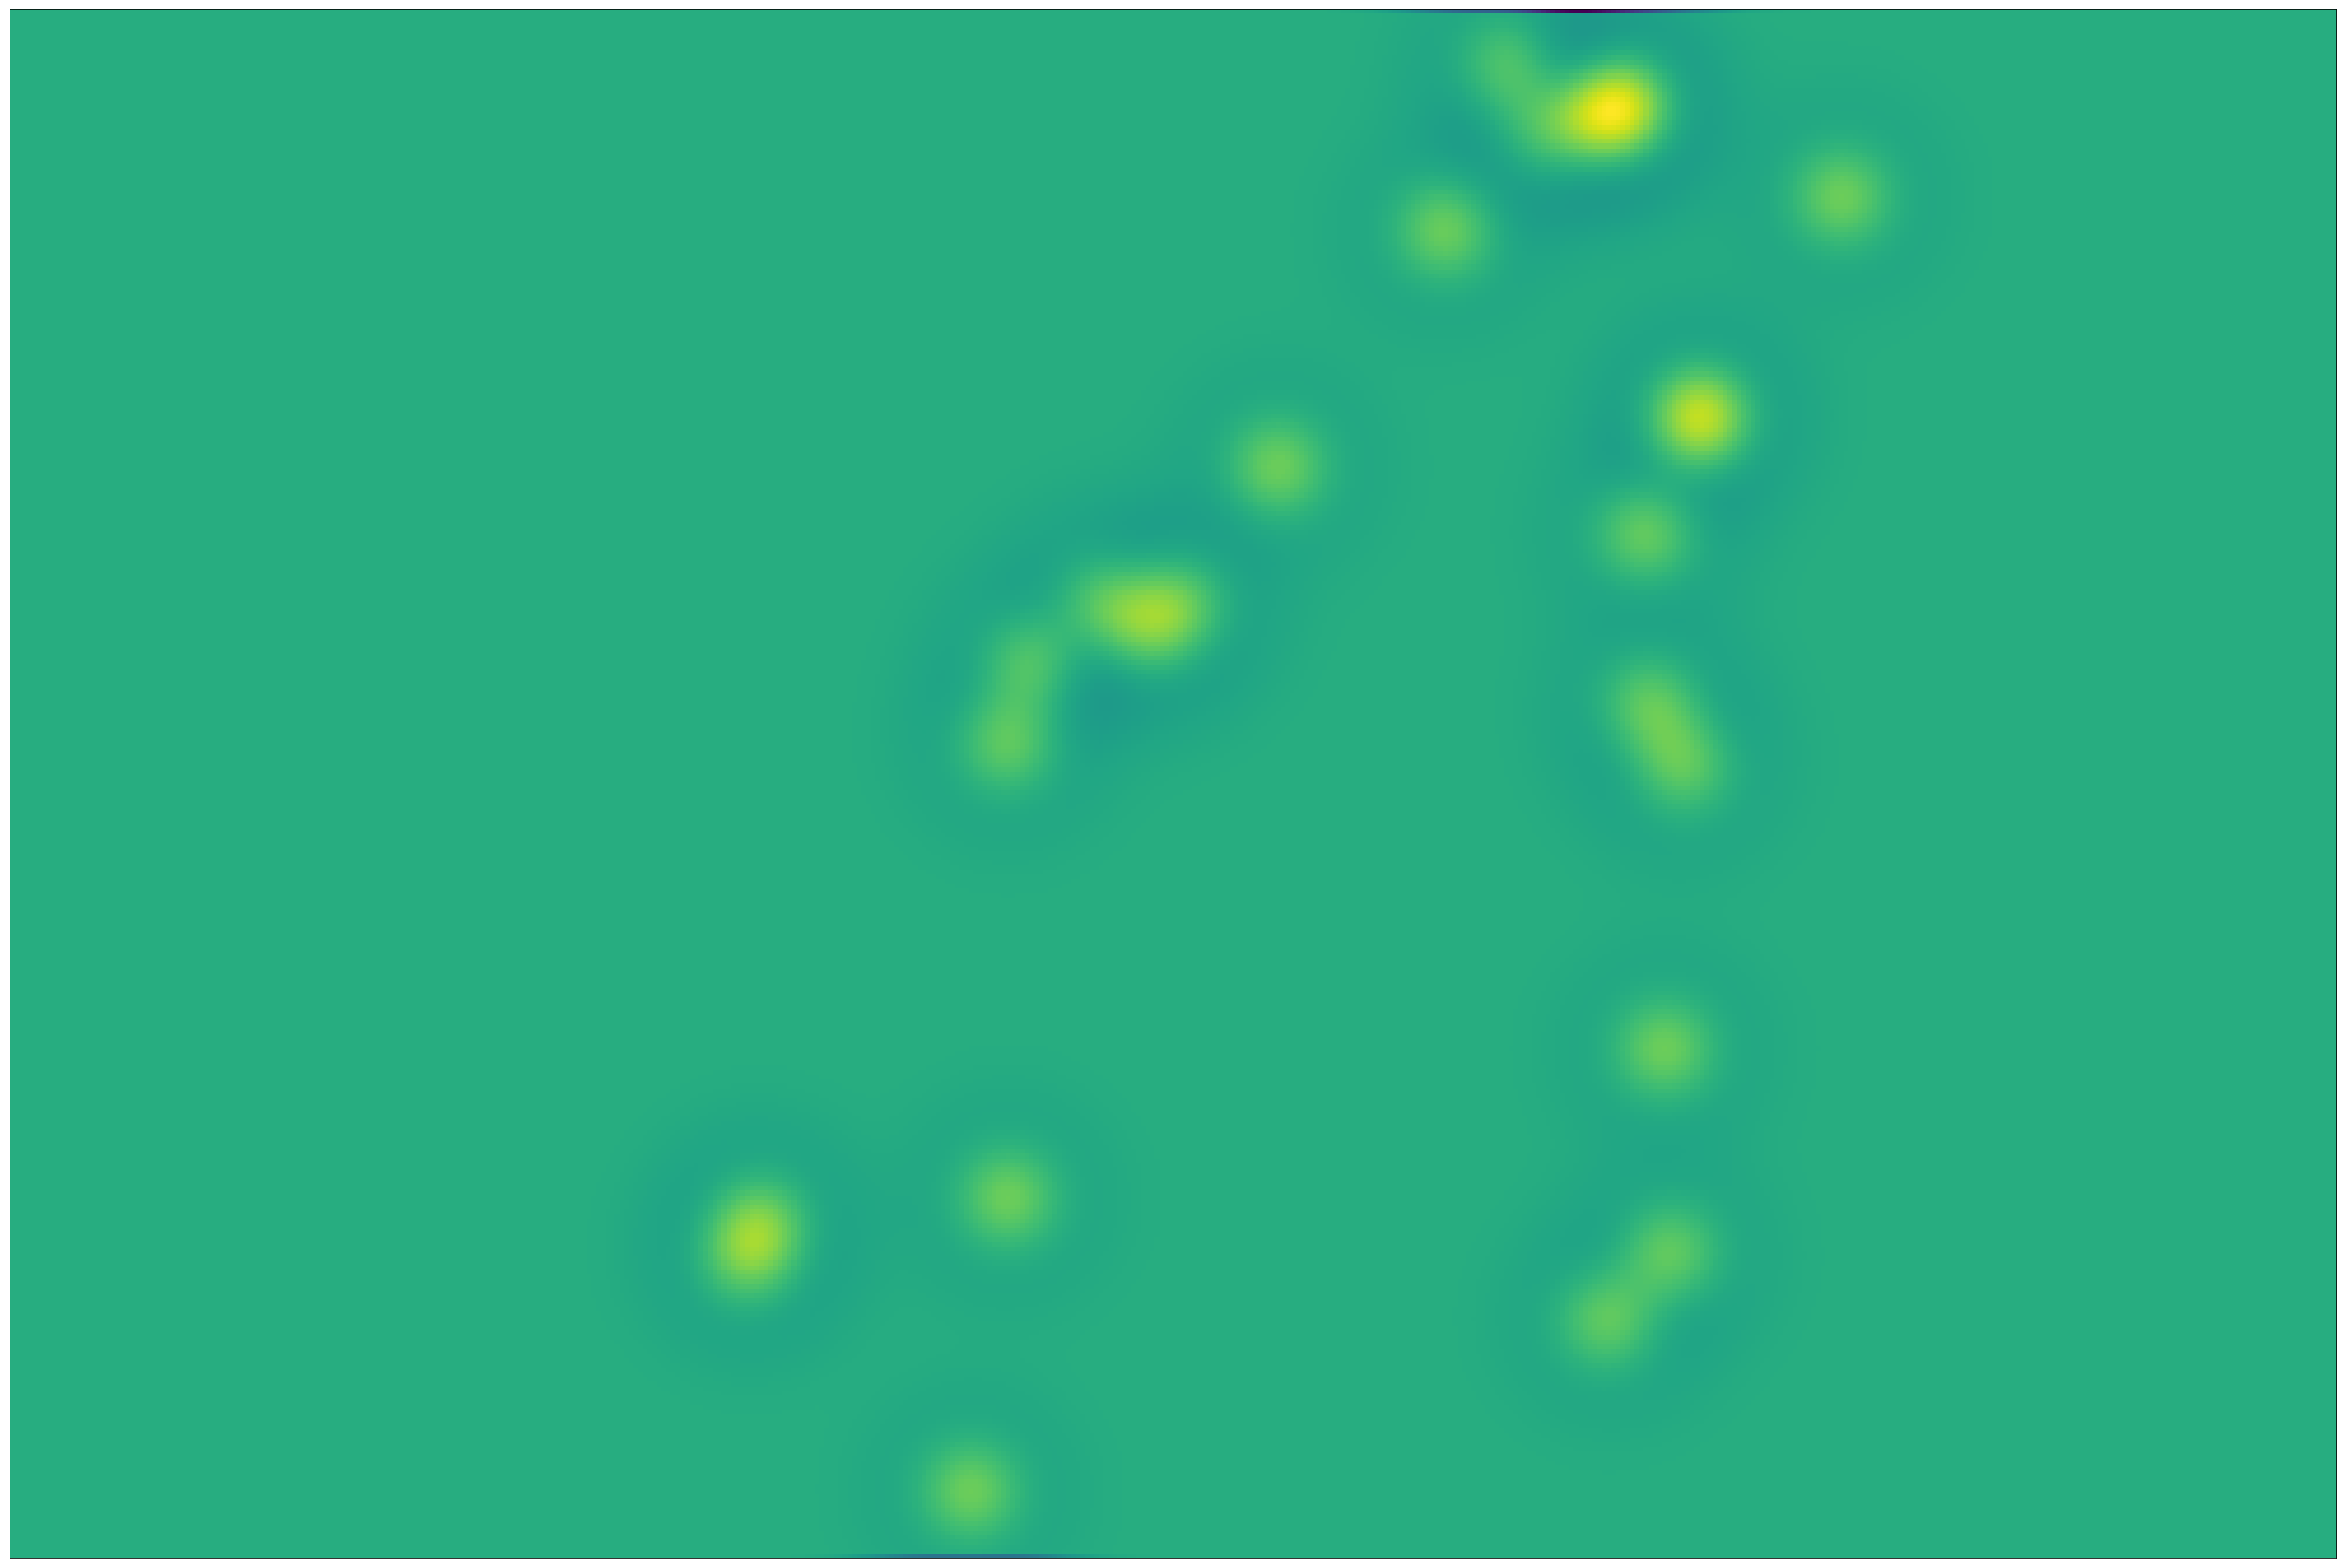

In [34]:
#ret_model=saved_receptive
image=normalized
#output computation
output=compute_normalized_output(receptive_fields,image)

#visualization of activated receptive fields
activated_ret=np.zeros(size)
for j in range(0,len(receptive_fields)):
    if (output[j]==1):
        activated_ret+=receptive_fields[j]

plt.figure(figsize=(50,33))

acti=plt.imshow(activated_ret)
acti.axes.get_yaxis().set_visible(False)
acti.axes.get_xaxis().set_visible(False)

plt.show()               

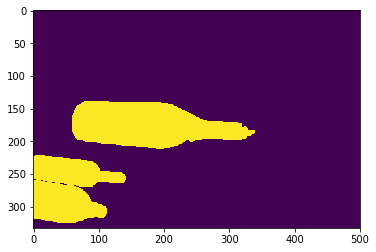

In [19]:
#visualize input '
plt.imshow(normalized)
plt.show()

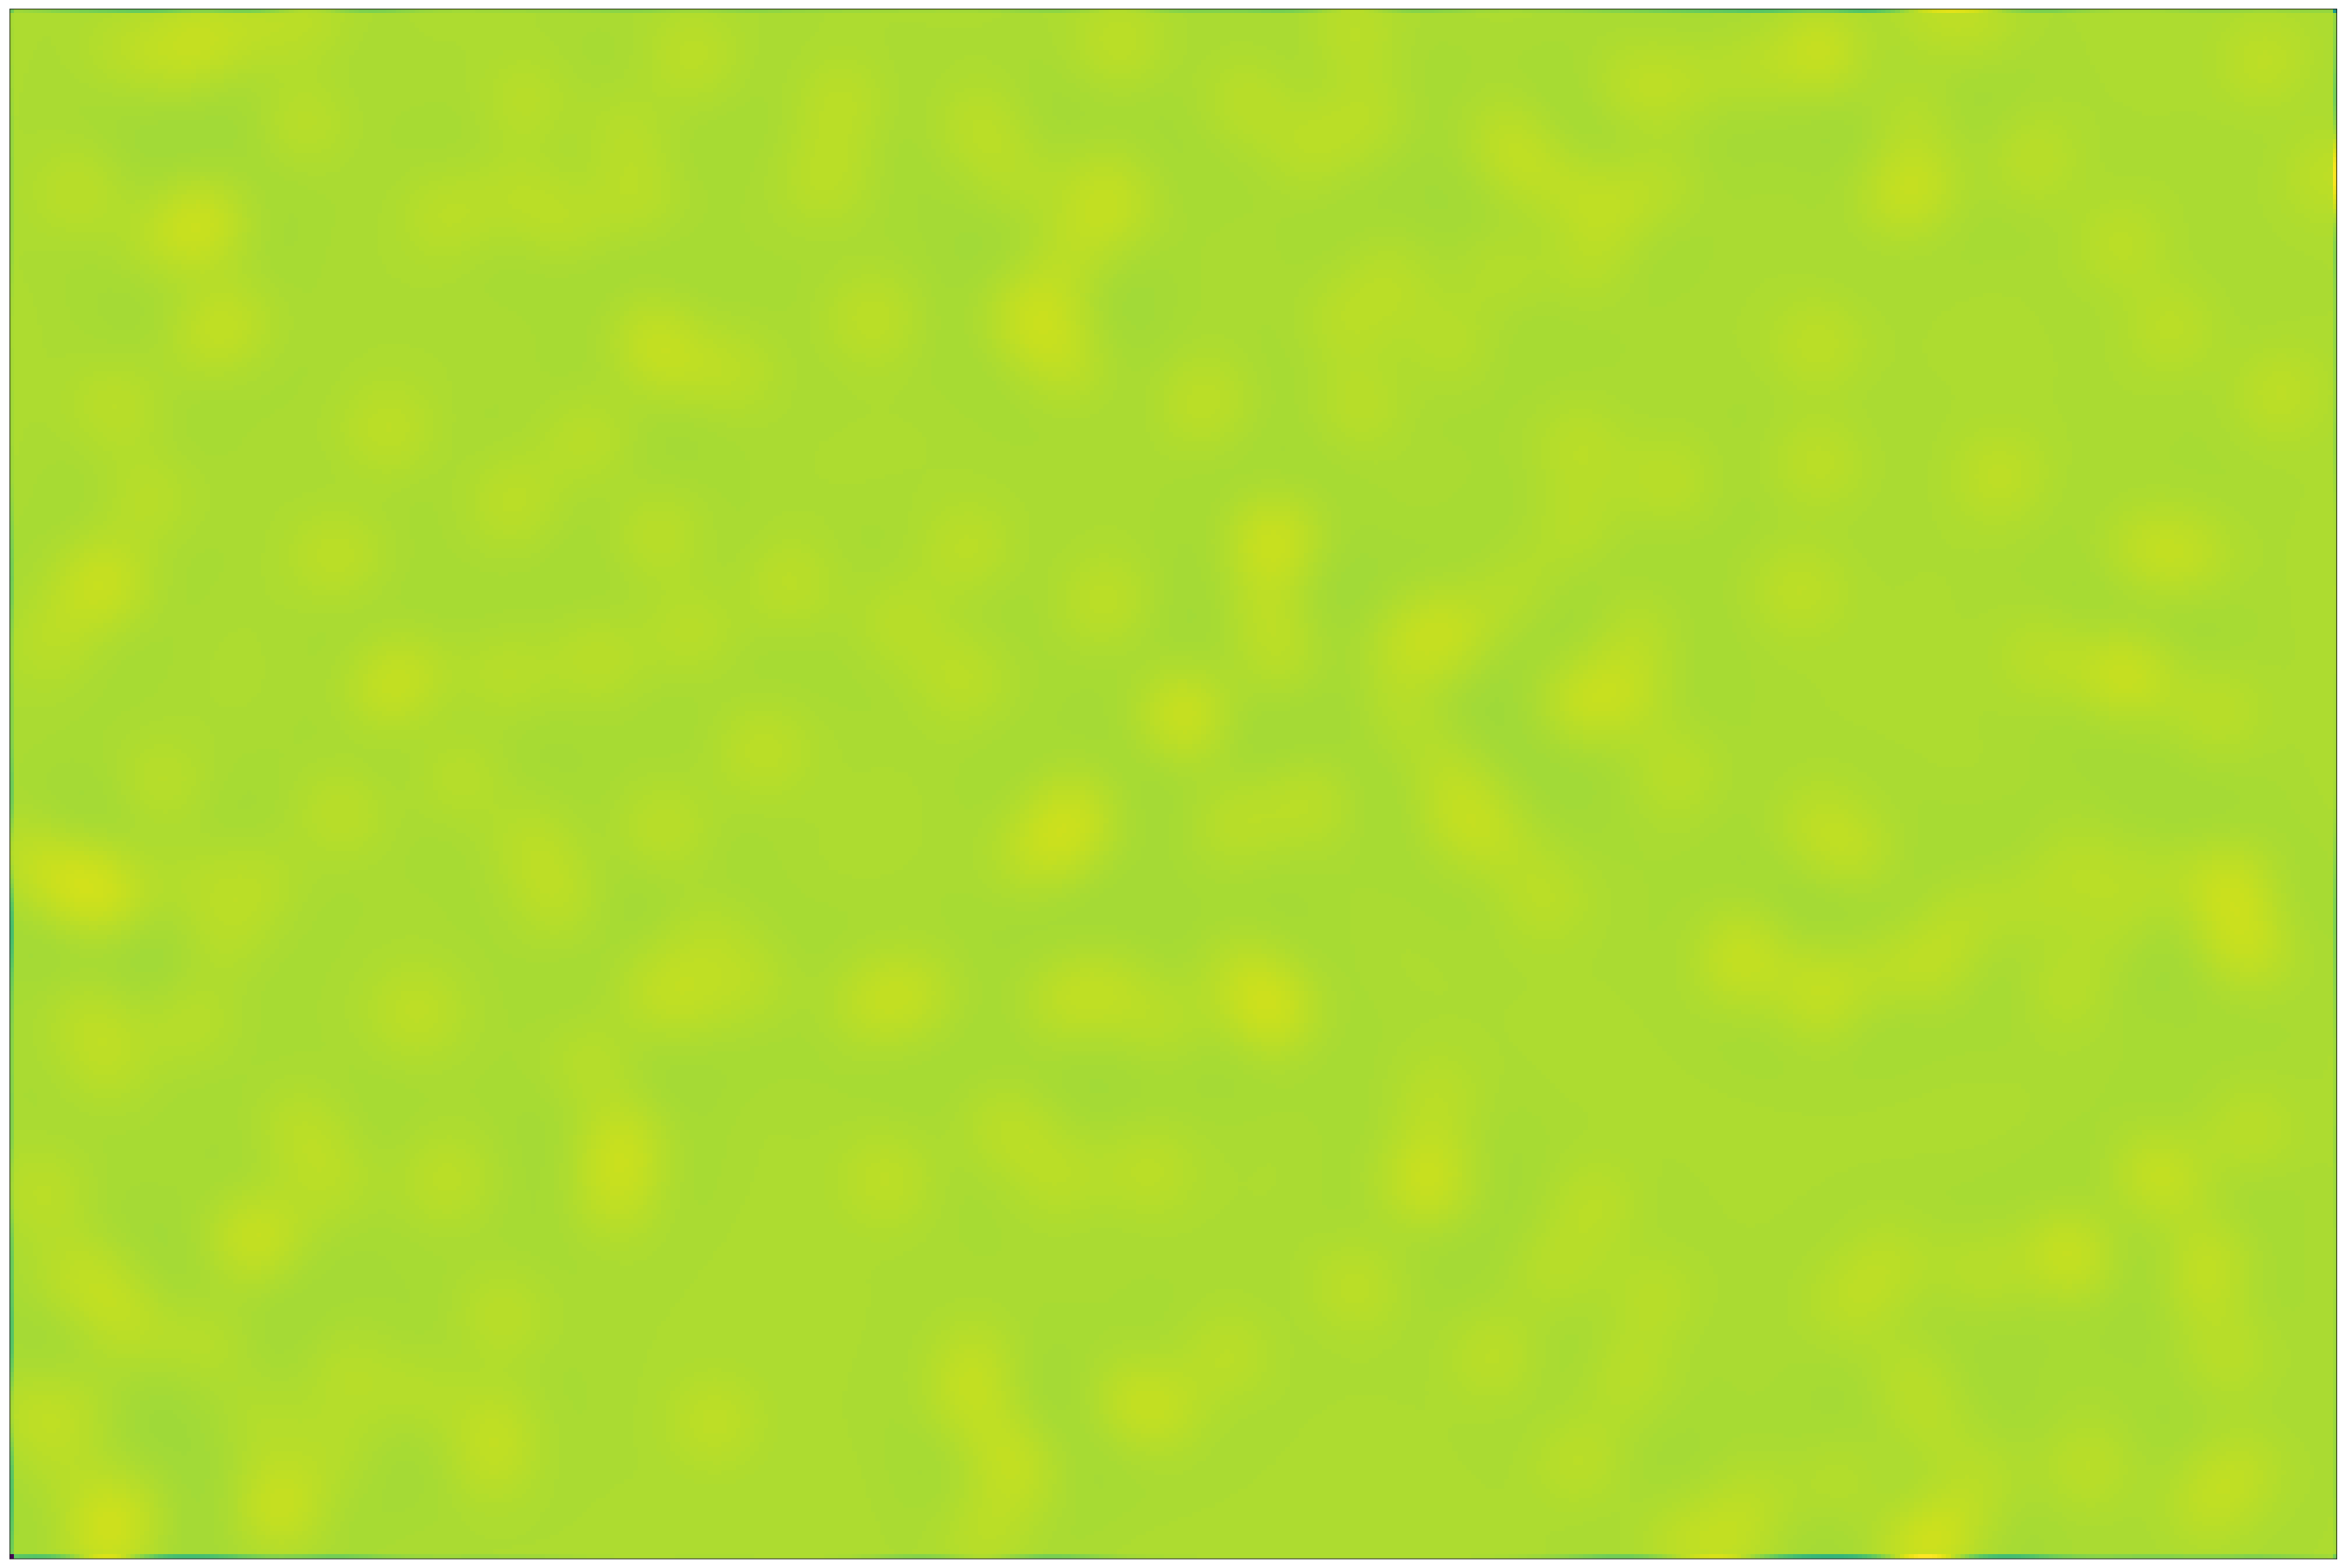

In [7]:
#visualization of the combined receptive fields
plt.figure(figsize=(50,33))
ret=np.sum(saved_receptive,axis=0)
fig=plt.imshow(ret)
fig.axes.get_yaxis().set_visible(False)
fig.axes.get_xaxis().set_visible(False)
plt.show()

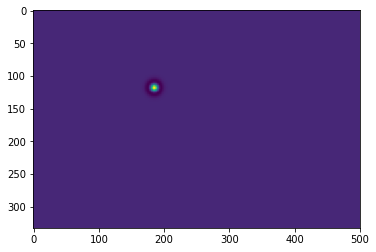

In [23]:
plt.imshow(ret_model[22])
plt.show()

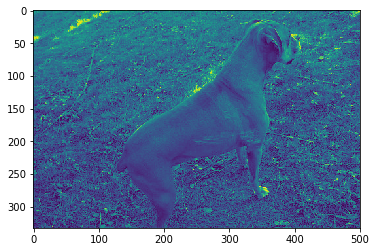

In [10]:
plt.imshow(normalized)
plt.show()

In [ ]:
#BATCH OPERATION AND RESULT SAVING FOR CLASSIFIER

In [47]:
src_folder = ".../IMAGE-SELECTION/SELECTION/combined/"
processed_folder = ".../IMAGE-SELECTION/processed/"
dest_folder=".../ganglion-activation/"
receptive_fields_path=".../Code/receptive_compressed250-70-8.npz"
types=os.listdir(src_folder)

In [48]:
#execute for all conditions and slightly varied for original images (different folders and loading)
def compute_learning_data(condition):
    #loads specified 'retina'
    receptive_fields =np.load(receptive_fields_path)['receptive']
    stimuli=[]
    truths=[]
    i=0
    for typee in types:
        print(typee)
        images =os.listdir(processed_folder+condition+"/"+typee+"/")
        print(len(images))
        for imagename in images: 
            #compute ganglion activations for current image
            stimulus=np.float_(np.sum(np.array(Image.open(processed_folder+condition+"/"+typee+"/"+imagename)),axis=2))/765.0
            stimuli.append(compute_normalized_output(receptive_fields,stimulus))
            #save class in truths list for supervised learning
            truths.append(types.index(typee))
            #status updates to estimate memory situation and time estimate
            i+=1
            if i%100==0:
                print(str(i))
    #free some memory before compression and saving            
    receptive_fields=[]
    #saves ganglion activations and true class for every image of the condition in the respective folder
    np.savez_compressed(dest_folder+condition+"/250full",stimuli=stimuli,truth=truths)
    #free some memory
    stimuli=[]
    truths=[]

In [49]:
#%time compute_learning_data('original')
%time compute_learning_data('outline-only')
%time compute_learning_data('background-blurring')
%time compute_learning_data('background-dark')
%time compute_learning_data('background-contrast')
%time compute_learning_data('segment-object')
%time compute_learning_data('segment-parts')
%time compute_learning_data('segment-binary')

chair
198
100
dog
665
200
300
400
500
600
700
800
bird
366
900
1000
1100
1200
bottle
117
1300
boat
243
1400
1500
tvmonitor
135
1600
1700
horse
202
1800
1900
aeroplane
386
2000
2100
2200
2300
person
903
2400
2500
2600
2700
2800
2900
3000
3100
3200
car
371
3300
3400
3500
CPU times: user 2min 11s, sys: 225 ms, total: 2min 11s
Wall time: 2min 12s
chair
198
100
dog
665
200
300
400
500
600
700
800
bird
366
900
1000
1100
1200
bottle
117
1300
boat
243
1400
1500
tvmonitor
135
1600
1700
horse
202
1800
1900
aeroplane
386
2000
2100
2200
2300
person
903
2400
2500
2600
2700
2800
2900
3000
3100
3200
car
371
3300
3400
3500
CPU times: user 2min 13s, sys: 248 ms, total: 2min 13s
Wall time: 2min 13s
chair
198
100
dog
665
200
300
400
500
600
700
800
bird
366
900
1000
1100
1200
bottle
117
1300
boat
243
1400
1500
tvmonitor
135
1600
1700
horse
202
1800
1900
aeroplane
386
2000
2100
2200
2300
person
903
2400
2500
2600
2700
2800
2900
3000
3100
3200
car
371
3300
3400
3500
CPU times: user 2min 11s, sys: 224 ms, t